# Deriving shareholding ownership

In [14]:
import numpy as np
from sympy import Matrix, diag
import networkx as nx
import pandas as pd

## Description of problem

Shareholding can be represented as a graph, comprising:
- Nodes of types:
    - Individual; and
    - Company
- Edges with weights representing ownership

In particular certain **Individuals** may have attributes of concern. These could be positive attributes or negative attributes. Either way, business units are interested in how these attributes *diffuse* across **Companies**.

### How would we ordinarily calculate the diffusion of **Individual** attributes to **Companies**?
### Acyclic case

In [74]:
nodes = {"INDIVIDUAL":["A", "B", "C"], "COMPANY": ["V","W", "X"]}
edges = [("A", "V", 0.7), ("B", "V", 0.3), ("V", "W", 0.2), ("C", "W", 0.8), ("W", "X", 1.0)]

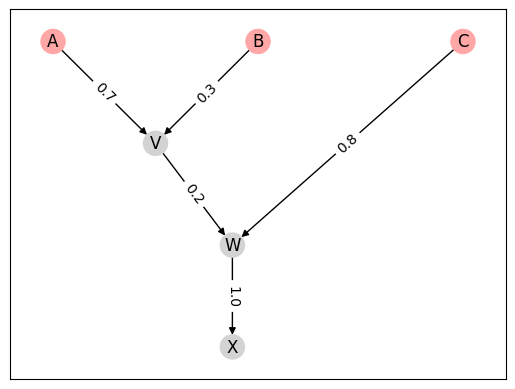

In [75]:
G = nx.DiGraph()
G.add_nodes_from(nodes["INDIVIDUAL"], type="INDIVDUAL")
G.add_nodes_from(nodes["COMPANY"], type="COMPANY")
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

pos=nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
colour_map = ["#ffa7a7" if node in nodes["INDIVIDUAL"] else "#d3d3d3" for node in G]
nx.draw_networkx(G, pos, node_color=colour_map);
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels);

In diagram above, directed edge from A to B means that A owns shares in B.
- **red** represents Individuals, who can only own shares in Companies. Nobody can own shares in an Individual.
- **grey** represents a Company who can own shares in another Company, and whose shareholding can be owned by Individuals or Companies.

Let's taint **A** and **C**. How does the taint affect **V**, **W**, and **X**? We simply perform a *depth-first traversal* from tainted nodes, and upon arriving at a **Company** node, we add the adjusted shareholding percentage to that **Company** node. For example, from **A** -> **V**, 0.7 of the taint is transferred. From the path **A** -> **V** onwards, the taint can only be 0.7 maximum, and in the path **A** -> **V** -> **W**, **W** is tainted $0.7 * 0.2 = 0.14$.

But things aren't always neat. Consider the cyclic case.
# Cyclic case

In [19]:
a = np.array([
    [1,0.9,0,0,0],
    [0,0,0.5,0,0],
    [0,0,0,1,0],
    [0,0.1,0,0,0],
    [0,0,0.5,0,1]
])

a = np.array([
    [1,0.9,0,0,0],
    [0,0,0.5,0,0],
    [0,0.1,0,0,0],
    [0,0.1,0,0,0],
    [0,0,0.5,0,1]
])

{(0, 0): Text(-0.46772671755024603, -0.5074047483932136, '1.0'),
 (0, 1): Text(-0.20405757209396536, -0.2985813605400296, '0.9'),
 (1, 2): Text(0.4115355496247679, 0.11441067351225086, '0.5'),
 (2, 1): Text(0.4115355496247679, 0.11441067351225086, '0.1'),
 (3, 1): Text(-0.47019421331884237, 0.3943328167052367, '0.1'),
 (4, 2): Text(0.7040575720939649, -0.14063044250863, '0.5'),
 (4, 4): Text(0.6446556183007093, -0.5998402047286073, '1.0')}

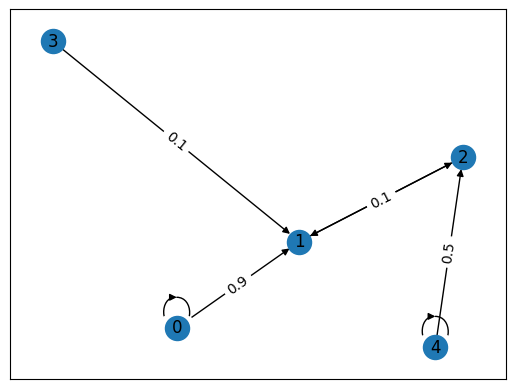

In [20]:
G = nx.from_numpy_matrix(a, create_using=nx.DiGraph)
pos = nx.spring_layout(G)
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


See http://www.columbia.edu/~ks20/stochastic-I/stochastic-I-MCII.pdf
- Individual node communicates with Company nodes, but not the other way around. i.e. if you start at a Company node, you cannot reach an Individual node.
- 

In [21]:
m = Matrix(a)

In [22]:
m

Matrix([
[1.0, 0.9,   0, 0,   0],
[  0,   0, 0.5, 0,   0],
[  0, 0.1,   0, 0,   0],
[  0, 0.1,   0, 0,   0],
[  0,   0, 0.5, 0, 1.0]])

In [23]:
m.pow(999)

Matrix([
[1.0,     0.947368421052632,     0.473684210526316, 0,   0],
[  0,                     0, 3.05493636349973e-650, 0,   0],
[  0, 6.10987272699946e-651,                     0, 0,   0],
[  0, 6.10987272699946e-651,                     0, 0,   0],
[  0,    0.0526315789473684,     0.526315789473684, 0, 1.0]])

In [24]:

a_I = np.array([[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]], dtype=np.complex_)
M_eigen = Matrix()
for idx, tup in enumerate(m.eigenvects()):
    a_I[idx][idx] = tup[0]
    M_eigen = M_eigen.col_insert(idx,tup[2][0])

In [25]:
(M_eigen**-1)*M_eigen

Matrix([
[1.0,   0, -1.31838984174237e-16, -1.31838984174237e-16,                    0],
[  0, 1.0, -9.84295337433817e-34,  1.48619554847185e-33, 6.84227765783602e-49],
[  0,   0,                   1.0,  1.17360552159731e-33,                    0],
[  0,   0,  1.95789456537934e-33,                   1.0, -1.3684555315672e-48],
[  0,   0, -5.55111512312578e-17,  5.55111512312578e-17,                  1.0]])

In [26]:
P,D=m.diagonalize()

In [27]:
P

Matrix([
[1.0,    0,  0.662291942972039,                1.0,   -0.171928747814649],
[  0,    0, -0.900427692795142, -0.862659113611134, 5.34472197203048e-33],
[  0,    0,  0.402683505982647, -0.385792883888842, 5.77275965394832e-33],
[  0, -1.0,  0.402683505982647, -0.385792883888842, 4.54111163955065e-34],
[  0,    0, -0.164547756159544,  0.248451997499977,   -0.889135243809464]])

In [28]:
P.inverse() == P**-1

True

In [29]:
m.eigenvects()

[(1.00000000000000,
  1,
  [Matrix([
   [1.0],
   [  0],
   [  0],
   [  0],
   [  0]])]),
 (0,
  1,
  [Matrix([
   [   0],
   [   0],
   [   0],
   [-1.0],
   [   0]])]),
 (-0.223606797749979,
  1,
  [Matrix([
   [ 0.662291942972039],
   [-0.900427692795142],
   [ 0.402683505982647],
   [ 0.402683505982647],
   [-0.164547756159544]])]),
 (0.223606797749979,
  1,
  [Matrix([
   [               1.0],
   [-0.862659113611134],
   [-0.385792883888842],
   [-0.385792883888842],
   [ 0.248451997499977]])]),
 (1.00000000000000,
  1,
  [Matrix([
   [  -0.171928747814649],
   [5.34472197203048e-33],
   [5.77275965394832e-33],
   [4.54111163955065e-34],
   [  -0.889135243809464]])])]

In [30]:
D.pow(10)

Matrix([
[1.0, 0,        0,        0,   0],
[  0, 0,        0,        0,   0],
[  0, 0, 3.125e-7,        0,   0],
[  0, 0,        0, 3.125e-7,   0],
[  0, 0,        0,        0, 1.0]])

In [31]:
D_alt = diag(1,0,0,0,1)

In [32]:
0.76760756*0.0685657

0.052631549676691994

In [33]:
P*D_alt*P.inverse()

Matrix([
[1.0,     0.947368421052632,     0.473684210526316, 0,                     0],
[  0, -3.16376117560511e-34, -3.16376117560511e-33, 0, -6.01114623364972e-33],
[  0, -3.41713431771323e-34, -3.41713431771324e-33, 0, -6.49255520365515e-33],
[  0, -2.68807110537889e-35, -2.68807110537889e-34, 0, -5.10733510021989e-34],
[  0,    0.0526315789473684,     0.526315789473684, 0,                   1.0]])

In [34]:
m.pow(9999)

Matrix([
[1.0,      0.947368421052632,      0.473684210526316, 0,   0],
[  0,                      0, 7.07981126105241e-6505, 0,   0],
[  0, 1.41596225221048e-6505,                      0, 0,   0],
[  0, 1.41596225221048e-6505,                      0, 0,   0],
[  0,     0.0526315789473684,      0.526315789473684, 0, 1.0]])

In [35]:
P*D.pow(1000)*P.inverse()

Matrix([
[1.0,     0.947368421052632,     0.473684210526316, 0,                     0],
[  0, -3.16376117560511e-34, -3.16376117560511e-33, 0, -6.01114623364972e-33],
[  0, -3.41713431771323e-34, -3.41713431771324e-33, 0, -6.49255520365515e-33],
[  0, -2.68807110537889e-35, -2.68807110537889e-34, 0, -5.10733510021989e-34],
[  0,    0.0526315789473684,     0.526315789473684, 0,                   1.0]])

In [36]:
I = Matrix(a_I)

In [37]:
I.pow(100)

Matrix([
[1.0, 0,                    0,                    0,   0],
[  0, 0,                    0,                    0,   0],
[  0, 0, 8.88178419700123e-66,                    0,   0],
[  0, 0,                    0, 8.88178419700123e-66,   0],
[  0, 0,                    0,                    0, 1.0]])

In [38]:
m.pow(999).T

Matrix([
[              1.0,                     0,                     0,                     0,                  0],
[0.947368421052632,                     0, 6.10987272699946e-651, 6.10987272699946e-651, 0.0526315789473684],
[0.473684210526316, 3.05493636349973e-650,                     0,                     0,  0.526315789473684],
[                0,                     0,                     0,                     0,                  0],
[                0,                     0,                     0,                     0,                1.0]])

In [39]:
m.jordan_form()

[Matrix([
 [  0, 1.0,   0, -4.02492235949962,  4.02492235949962],
 [  0,   0,   0,  5.47213595499958, -3.47213595499958],
 [  0,   0,   0, -2.44721359549996, -1.55278640450004],
 [1.0,   0,   0, -2.44721359549996, -1.55278640450004],
 [  0,   0, 1.0,               1.0,               1.0]]),
 Matrix([
 [0,   0,   0,                  0,                 0],
 [0, 1.0,   0,                  0,                 0],
 [0,   0, 1.0,                  0,                 0],
 [0,   0,   0, -0.223606797749979,                 0],
 [0,   0,   0,                  0, 0.223606797749979]])]

In [40]:
sym_eignvects = []
for tup in m.eigenvects():
    for v in tup[2]:
        sym_eignvects.append(list(v))
for eigenvect in m.T.eigenvects():
    print(eigenvect)
    print("===")
# print(m.eigenvals())

(1.00000000000000, 1, [Matrix([
[0.686497904853428],
[0.650366436176932],
[0.325183218088466],
[                0],
[                0]])])
===
(-0.223606797749979, 1, [Matrix([
[6.29003810514703e-65],
[   0.408448919408353],
[  -0.913319549133411],
[                   0],
[                   0]])])
===
(0.223606797749979, 1, [Matrix([
[5.4594281676129e-64],
[ -0.628691755035644],
[  -1.40579750115335],
[                  0],
[                  0]])])
===
(0, 1, [Matrix([
[ 1.31007910076992e-64],
[-1.56656453416143e-67],
[   -0.788369347605901],
[    0.788369347605901],
[                    0]])])
===
(1.00000000000000, 1, [Matrix([
[ -0.144979771881992],
[-0.0958561340142084],
[  0.346256606795846],
[                  0],
[  0.788369347605901]])])
===


In [41]:
a_alt = np.array([
    [1,0],
    [2,0]
])
m_alt = Matrix(a_alt)
sym_eignvects = []
for tup in m_alt.eigenvects():
    for v in tup[2]:
        sym_eignvects.append(list(v))
sym_eignvects
print(m_alt.eigenvects())
print(m_alt.eigenvals())

[(0, 1, [Matrix([
[0],
[1]])]), (1, 1, [Matrix([
[1/2],
[  1]])])]
{1: 1, 0: 1}


In [42]:
m.eigenvects()[0][2][0]

Matrix([
[1.0],
[  0],
[  0],
[  0],
[  0]])

In [43]:
m.eigenvects()

[(1.00000000000000,
  1,
  [Matrix([
   [1.0],
   [  0],
   [  0],
   [  0],
   [  0]])]),
 (0,
  1,
  [Matrix([
   [   0],
   [   0],
   [   0],
   [-1.0],
   [   0]])]),
 (-0.223606797749979,
  1,
  [Matrix([
   [ 0.662291942972039],
   [-0.900427692795142],
   [ 0.402683505982647],
   [ 0.402683505982647],
   [-0.164547756159544]])]),
 (0.223606797749979,
  1,
  [Matrix([
   [               1.0],
   [-0.862659113611134],
   [-0.385792883888842],
   [-0.385792883888842],
   [ 0.248451997499977]])]),
 (1.00000000000000,
  1,
  [Matrix([
   [  -0.171928747814649],
   [5.34472197203048e-33],
   [5.77275965394832e-33],
   [4.54111163955065e-34],
   [  -0.889135243809464]])])]

In [44]:
m.T.eigenvects()

[(1.00000000000000,
  1,
  [Matrix([
   [0.686497904853428],
   [0.650366436176932],
   [0.325183218088466],
   [                0],
   [                0]])]),
 (-0.223606797749979,
  1,
  [Matrix([
   [6.29003810514703e-65],
   [   0.408448919408353],
   [  -0.913319549133411],
   [                   0],
   [                   0]])]),
 (0.223606797749979,
  1,
  [Matrix([
   [5.4594281676129e-64],
   [ -0.628691755035644],
   [  -1.40579750115335],
   [                  0],
   [                  0]])]),
 (0,
  1,
  [Matrix([
   [ 1.31007910076992e-64],
   [-1.56656453416143e-67],
   [   -0.788369347605901],
   [    0.788369347605901],
   [                    0]])]),
 (1.00000000000000,
  1,
  [Matrix([
   [ -0.144979771881992],
   [-0.0958561340142084],
   [  0.346256606795846],
   [                  0],
   [  0.788369347605901]])])]

In [45]:
m.left_eigenvects()

[(1.00000000000000,
  1,
  [Matrix([[0.686497904853428, 0.650366436176932, 0.325183218088466, 0, 0]])]),
 (-0.223606797749979,
  1,
  [Matrix([[6.29003810514703e-65, 0.408448919408353, -0.913319549133411, 0, 0]])]),
 (0.223606797749979,
  1,
  [Matrix([[5.4594281676129e-64, -0.628691755035644, -1.40579750115335, 0, 0]])]),
 (0,
  1,
  [Matrix([[1.31007910076992e-64, -1.56656453416143e-67, -0.788369347605901, 0.788369347605901, 0]])]),
 (1.00000000000000,
  1,
  [Matrix([[-0.144979771881992, -0.0958561340142084, 0.346256606795846, 0, 0.788369347605901]])])]

In [46]:
m.left_eigenvects()[0][2][0]

Matrix([[0.686497904853428, 0.650366436176932, 0.325183218088466, 0, 0]])

In [47]:
m.left_eigenvects()[0][2][0]

Matrix([[0.686497904853428, 0.650366436176932, 0.325183218088466, 0, 0]])

In [48]:
m.left_eigenvects()[0][2][0]*m.pow(1)

Matrix([[0.686497904853428, 0.650366436176932, 0.325183218088466, 0, 0]])

In [49]:
m.pow(1001)

Matrix([
[1.0,     0.947368421052632,     0.473684210526316, 0,   0],
[  0,                     0, 1.52746818174986e-651, 0,   0],
[  0, 3.05493636349973e-652,                     0, 0,   0],
[  0, 3.05493636349973e-652,                     0, 0,   0],
[  0,    0.0526315789473684,     0.526315789473684, 0, 1.0]])

In [50]:
m.pow(5)

Matrix([
[1.0, 0.94725,  0.4725, 0,   0],
[  0,       0, 0.00125, 0,   0],
[  0, 0.00025,       0, 0,   0],
[  0, 0.00025,       0, 0,   0],
[  0,  0.0525, 0.52625, 0, 1.0]])

In [51]:
m.pow(1)

Matrix([
[1.0, 0.9,   0, 0,   0],
[  0,   0, 0.5, 0,   0],
[  0, 0.1,   0, 0,   0],
[  0, 0.1,   0, 0,   0],
[  0,   0, 0.5, 0, 1.0]])

In [52]:
a_test = np.array([[0.5,0.4,0.1],[0.3,0.4,0.3],[0.2,0.3,0.5]])
m_test = Matrix(a_test)

{(0, 0): Text(-1.0, -0.4315595560116549, '0.5'),
 (0, 1): Text(-0.4865983974584228, 0.24475001114023479, '0.4'),
 (0, 2): Text(-0.013401602541577184, -0.46052978914606224, '0.1'),
 (1, 0): Text(-0.4865983974584228, 0.24475001114023479, '0.3'),
 (1, 1): Text(0.026803205083154338, 0.9210595782921245, '0.4'),
 (1, 2): Text(0.5, 0.21577977800582748, '0.3'),
 (2, 0): Text(-0.013401602541577184, -0.46052978914606224, '0.2'),
 (2, 1): Text(0.5, 0.21577977800582748, '0.3'),
 (2, 2): Text(0.9731967949168456, -0.4895000222804695, '0.5')}

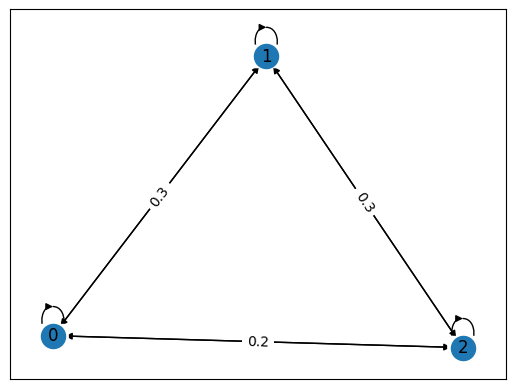

In [53]:
G = nx.from_numpy_matrix(a_test, create_using=nx.DiGraph)
pos = nx.spring_layout(G)
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


In [54]:
sum(m_test.left_eigenvects()[0][2][0])

1.72355263742428

In [55]:
m_test.left_eigenvects()[0][2][0]/sum(m_test.left_eigenvects()[0][2][0])

Matrix([[0.338709677419355, 0.370967741935484, 0.290322580645161]])

In [56]:
m_test.pow(1000)

Matrix([
[0.338709677419357, 0.370967741935486, 0.290322580645163],
[0.338709677419357, 0.370967741935486, 0.290322580645163],
[0.338709677419357, 0.370967741935486, 0.290322580645163]])